# MLP Models to Compute Heritage Values and Attributes

## Imports

In [1]:
import os
import os.path as osp
from itertools import product
from typing import Callable, List, Optional

import numpy as np
import scipy.sparse as sp

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import pandas as pd

import random

import torch
torch.manual_seed(1337)
torch.backends.cudnn.benchmark = True

from torch_geometric.transforms import RandomLinkSplit, ToUndirected
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv, Linear, to_hetero

import torch.nn.functional as F
from torch_geometric import seed_everything

from tqdm import tqdm
import torch.optim as optim
import pickle

In [3]:
from torch_geometric.nn import MLP

In [4]:
os.getcwd()

'D:\\surf\\TUD\\Paper\\Venice_Graph'

In [5]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.10.2
GPU-enabled installation? True


In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [8]:
args = Namespace(
    # Data and Path information
    path = 'dataset/Venice',
    save_dir='model_storage/MLP/',
    model_state_file='model.pth',
    
    # Model hyper parameters
    hidden_channels = 256,
    num_layers = 3,
    k=3,
    
    # Training hyper parameters
    sample_nodes = 25,
    batch_size=32,
    early_stopping_criteria=30,
    learning_rate=0.001,
    l2=2e-4,
    dropout_p=0.1,
    num_epochs=300,
    seed=42,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

In [9]:
if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

# handle dirs
handle_dirs(args.save_dir)    

Expanded filepaths: 
	model_storage/MLP/model.pth


## Constructing Dataset

In [10]:
class VEN(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (1,190 nodes), nodes with both visual and textual
    features 'vis_tex' (1,761 nodes) and four types of links - social similarity
    'SOC' (488,103 links), spatial similarity (445,779 links), temporal similarity
    (501,191 links), and simple composed link (1,071,977 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [11]:
class VEN_Homo(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_Homo is a homogeneous graph containing 2951 nodes and 1,071,977 links.
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = Data()

        link_types = ['simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])

        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data.num_nodes = len(node_type_idx)

        data.x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data.y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx
        
        data.att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data.val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            mask[idx] = True
            data[f'{name}_mask'] = mask
                    
        s = {}
        
        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data.edge_index = torch.stack([row, col], dim=0)
                data.edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [13]:
class VEN_XL(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1QZ5tyUWs6jYjh7mJrsnpou76iy-vb0CA'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)
        
        data['all'].att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data['all'].val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))
        data['all'].node_type = node_type_idx

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [14]:
class VEN_XL_Homo(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = Data()

        link_types = ['simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])

        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data.num_nodes = len(node_type_idx)

        data.x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data.y = torch.from_numpy(ys).to(torch.float)
        
        data.att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data.val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data.num_nodes, dtype=torch.bool)
            mask[idx] = True
            data[f'{name}_mask'] = mask
                    
        s = {}
        
        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data.edge_index = torch.stack([row, col], dim=0)
                data.edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [15]:
#path = osp.join(os.getcwd(), '../../data/VEN')
transform = T.NormalizeFeatures()
dataset = VEN_Homo('dataset/Venice_homo')
data = dataset[0]

In [16]:
data.n_id = torch.arange(data.num_nodes)
data = data.to(device)
data

Data(num_nodes=2951, x=[2951, 1753], y=[2951, 20], node_type=[2951], att_lab=[2951], val_lab=[2951], train_mask=[2951], val_mask=[2951], test_mask=[2951], edge_index=[2, 1071977], edge_attr=[1071977], n_id=[2951])

In [17]:
data.x

tensor([[1.2861, 0.3745, 1.1453,  ..., 1.0000, 0.0000, 0.0000],
        [0.3977, 0.1582, 0.3059,  ..., 1.0000, 0.0000, 0.0000],
        [0.5185, 0.5124, 1.3662,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.0124, 1.7083, 0.3258,  ..., 0.0000, 1.0000, 0.0000],
        [0.4402, 0.8374, 0.4974,  ..., 0.0000, 1.0000, 0.0000],
        [0.2102, 1.5535, 0.3352,  ..., 0.0000, 1.0000, 0.0000]],
       device='cuda:0')

In [18]:
data.att_lab.sum()

tensor(1356, device='cuda:0')

## Data Loader for Sampling

In [19]:
from torch_geometric.loader import NeighborLoader

In [20]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.train_mask,
)

In [21]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.val_mask,
)

In [22]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data.test_mask,
)

In [23]:
sampled_data = next(iter(train_loader))
batch = sampled_data
batch

Data(num_nodes=2915, x=[2915, 1753], y=[2915, 20], node_type=[2915], att_lab=[2915], val_lab=[2915], train_mask=[2915], val_mask=[2915], test_mask=[2915], edge_index=[2, 102001], edge_attr=[102001], n_id=[2915], batch_size=32)

## Helper Function

In [20]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_ATT_acc_val': 0,
            'early_stopping_best_VAL_acc_val': 0,
            'early_stopping_best_ATT_acc_val_2': 0,
            'early_stopping_lowest_loss': 1000,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_ATT_loss': [],
            'train_VAL_loss':[],
            'train_ATT_acc': [],
            'train_VAL_acc': [],
            'train_VAL_jac': [],
            'train_VAL_acc_1':[], 
            'val_loss': [],
            'val_ATT_loss': [],
            'val_VAL_loss':[],
            'val_ATT_acc': [],
            'val_VAL_acc': [],
            'val_VAL_jac': [],
            'val_VAL_acc_1': [],
            'test_loss': -1,
            'test_ATT_loss': -1,
            'test_VAL_loss':-1,
            'test_ATT_acc': -1,
            'test_VAL_acc': -1,
            'test_VAL_jac': -1,
            'test_VAL_acc_1': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        ATT_acc_tm1, ATT_acc_t = train_state['val_ATT_acc'][-2:]
        #ATT_acc_2_tm1, ATT_acc_2_t = train_state['val_ATT_acc_2'][-2:]
        VAL_acc_tm1, VAL_acc_t = train_state['val_VAL_acc'][-2:]
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If accuracy worsened
        #if loss_t >= train_state['early_stopping_lowest_loss']:
        #    train_state['early_stopping_step'] += 1
        
        if ATT_acc_t <= train_state['early_stopping_best_ATT_acc_val'] and VAL_acc_t <= train_state['early_stopping_best_VAL_acc_val']:# and ATT_acc_2_t <= train_state['early_stopping_best_ATT_acc_val_2']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if VAL_acc_t > train_state['early_stopping_best_VAL_acc_val']:
                train_state['early_stopping_best_VAL_acc_val'] = VAL_acc_t
                
            if ATT_acc_t > train_state['early_stopping_best_ATT_acc_val']:
                train_state['early_stopping_best_ATT_acc_val'] = ATT_acc_t
            
            #if ATT_acc_2_t > train_state['early_stopping_best_ATT_acc_val_2']:
            #    train_state['early_stopping_best_ATT_acc_val_2'] = ATT_acc_2_t
                
            if loss_t < train_state['early_stopping_lowest_loss']:
                train_state['early_stopping_lowest_loss'] = loss_t
                torch.save(model.state_dict(), train_state['model_filename'])
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [21]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [22]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

## Searched Best Hyper-parameter

In [29]:
with open(args.save_dir+'42/hyperdict.p', 'rb') as fp:
    hyperdict= pickle.load(fp)

In [30]:
len(hyperdict)

135

In [31]:
hyper_df = pd.DataFrame(hyperdict).T

In [35]:
hyper_df[(hyper_df.early_stopping_best_VAL_acc_val + hyper_df.early_stopping_best_VAL_acc_val)>190]

stop_early early_stopping_step early_stopping_best_ATT_acc_val  \
0.1 2 512 0.01       True                  30                       87.913669   
0.2 2 256 0.01       True                  30                       87.194245   
      512 0.01       True                  30                       86.906475   
    3 512 0.01       True                  30                       87.482014   
0.5 2 512 0.01       True                  30                       85.755396   

               early_stopping_best_VAL_acc_val  \
0.1 2 512 0.01                       96.978417   
0.2 2 256 0.01                       95.251799   
      512 0.01                       98.129496   
    3 512 0.01                       98.705036   
0.5 2 512 0.01                        99.42446   

               early_stopping_best_ATT_acc_val_2 early_stopping_lowest_loss  \
0.1 2 512 0.01                                 0                   4.283473   
0.2 2 256 0.01                                 0                   4.247989   
      512 0.01                                 0                   4.233886   
    3 512 0.01                                 0                    4.23534   
0.5 2 512 0.01                                 0                   4.218476   

               learning_rate epoch_index  \
0.1 2 512 0.01          0.01          81   
0.2 2 256 0.01          0.01          40   
      512 0.01          0.01         142   
    3 512 0.01          0.01         112   
0.5 2 512 0.01          0.01          61   

                                                       train_loss  \
0.1 2 512 0.01  [3.668607771396637, 2.8671470483144126, 2.6329...   
0.2 2 256 0.01  [3.4082926511764526, 2.7423266967137656, 2.622...   
      512 0.01  [3.684901793797811, 2.8937514623006186, 2.7011...   
    3 512 0.01  [3.980452517668406, 3.006455639998118, 2.69875...   
0.5 2 512 0.01  [3.8542353312174478, 3.08571062485377, 2.85462...   

                                                   train_ATT_loss  ...  \
0.1 2 512 0.01  [1.6286450495680282, 0.9909614489679521, 0.998...  ...   
0.2 2 256 0.01  [1.3227104675076344, 0.9560339421116414, 0.841...  ...   
      512 0.01  [1.5665503717195295, 1.0540965808725753, 0.989...  ...   
    3 512 0.01  [1.9148970105971657, 0.9970721310195501, 1.037...  ...   
0.5 2 512 0.01  [1.6187379809297684, 1.0744382905827996, 0.968...  ...   

                                                      val_VAL_acc  \
0.1 2 512 0.01  [56.97841726618705, 55.97122302158273, 57.6978...   
0.2 2 256 0.01  [58.992805755395686, 63.7410071942446, 87.9136...   
      512 0.01  [57.697841726618705, 55.10791366906475, 88.201...   
    3 512 0.01  [87.4820143884892, 92.5179856115108, 94.244604...   
0.5 2 512 0.01  [62.87769784172662, 56.83453237410072, 79.1366...   

                                                      val_VAL_jac test_loss  \
0.1 2 512 0.01  [0.1157656767385469, 0.10939705817819499, 0.12...        -1   
0.2 2 256 0.01  [0.12546762785465598, 0.1313429269859259, 0.13...        -1   
      512 0.01  [0.11342240872142983, 0.11150565833496533, 0.1...        -1   
    3 512 0.01  [0.12217197778413622, 0.13116649723739074, 0.1...        -1   
0.5 2 512 0.01  [0.11468996452770645, 0.12218568067756488, 0.1...        -1   

               test_ATT_loss test_VAL_loss test_ATT_acc test_ATT_acc_2  \
0.1 2 512 0.01            -1            -1           -1             -1   
0.2 2 256 0.01            -1            -1           -1             -1   
      512 0.01            -1            -1           -1             -1   
    3 512 0.01            -1            -1           -1             -1   
0.5 2 512 0.01            -1            -1           -1             -1   

               test_VAL_acc test_VAL_jac               model_filename  
0.1 2 512 0.01           -1           -1  model_storage/MLP/model.pth  
0.2 2 256 0.01           -1           -1  model_storage/MLP/model.pth  
      512 0.01           -1           -1  model_storage/MLP/model.pth  
    

In [34]:
hyper_df[(hyper_df.early_stopping_lowest_loss<4.13)]

stop_early early_stopping_step  \
0.1 3 256 0.0010       True                  30   
          0.0005       True                  30   
    5 256 0.0005       True                  30   
0.2 2 512 0.0005       True                  30   
    3 256 0.0010       True                  30   
          0.0005       True                  30   
      512 0.0010       True                  30   
0.5 3 512 0.0010       True                  30   

                 early_stopping_best_ATT_acc_val  \
0.1 3 256 0.0010                       91.510791   
          0.0005                       92.230216   
    5 256 0.0005                       89.928058   
0.2 2 512 0.0005                       91.942446   
    3 256 0.0010                       91.223022   
          0.0005                       91.079137   
      512 0.0010                       90.791367   
0.5 3 512 0.0010                       90.647482   

                 early_stopping_best_VAL_acc_val  \
0.1 3 256 0.0010                       71.366906   
          0.0005                       73.381295   
    5 256 0.0005                       83.309353   
0.2 2 512 0.0005                       74.100719   
    3 256 0.0010                       75.395683   
          0.0005                        73.81295   
      512 0.0010                       67.338129   
0.5 3 512 0.0010                       74.388489   

                 early_stopping_best_ATT_acc_val_2 early_stopping_lowest_loss  \
0.1 3 256 0.0010                                 0                    4.11884   
          0.0005                                 0                   4.113167   
    5 256 0.0005                                 0                   4.127223   
0.2 2 512 0.0005                                 0                   4.126685   
    3 256 0.0010                                 0                   4.121039   
          0.0005                                 0                   4.128302   
      512 0.0010                                 0                    4.12224   
0.5 3 512 0.0010                                 0                   4.127274   

                 learning_rate epoch_index  \
0.1 3 256 0.0010         0.001         200   
          0.0005        0.0005         201   
    5 256 0.0005        0.0005         161   
0.2 2 512 0.0005        0.0005         144   
    3 256 0.0010         0.001         101   
          0.0005        0.0005         103   
      512 0.0010         0.001          81   
0.5 3 512 0.0010         0.001         137   

                                                         train_loss  \
0.1 3 256 0.0010  [3.3199336926142373, 2.6071802377700806, 2.500...   
          0.0005  [3.593160013357798, 2.682584981123606, 2.51767...   
    5 256 0.0005  [3.8874157071113586, 2.8924161195755005, 2.640...   
0.2 2 512 0.0005  [3.225165367126465, 2.5821815530459085, 2.4668...   
    3 256 0.0010  [3.4373897711435952, 2.716141859690348, 2.5443...   
          0.0005  [3.6888991792996726, 2.795999844868978, 2.5873...   
      512 0.0010  [3.18015193939209, 2.6315991481145224, 2.53178...   
0.5 3 512 0.0010  [3.5991070667902627, 2.949184517065684, 2.7242...   

                                                     train_ATT_loss  ...  \
0.1 3 256 0.0010  [1.1809954174337625, 0.8182199795490487, 0.780...  ...   
          0.0005  [1.5237200521035867, 0.9307283595658405, 0.791...  ...   
    5 256 0.0005  [1.942243436697117, 1.1255941513172478, 0.8200...  ...   
0.2 2 512 0.0005  [1.0910309771091324, 0.8361637635244227, 0.784...  ...   
    3 256 0.0010  [1.2536587077825023, 0.8496173643339374, 0.787...  ...   
          0.0005  [1.5622473000819663, 0.9837408716328586, 0.805...  ...   
      512 0.0010  [1.0501962424645463, 0.8789123669885862, 0.818...  ...   
0.5 3 512 0.0010  [1.3044477602121243, 0.9235615568478022, 0.822...  ...   

                                                        val_VAL_acc  \
0.1 3 256 0.0010  [60.431654676258994, 60.0, 59.13669064748201, ...   
       

In [38]:
(hyper_df['val_VAL_loss'].apply(lambda x: min(x)) + hyper_df['val_ATT_loss'].apply(lambda x: min(x))).index[25]

(0.1, 3, 256, 0.001)

## Re-run model and get Inference Data

In [23]:
def initialization():
    set_seed_everywhere(args.seed, args.cuda)
    #transform = T.Compose([T.ToSparseTensor()])
    dataset = VEN_Homo('dataset/Venice_homo')
    data = dataset[0]
    data.n_id = torch.arange(data.num_nodes)
    data = data.to(device)
    
    train_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling training nodes
        batch_size=args.batch_size,
        input_nodes=data.train_mask,
    )
    val_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling validating nodes
        batch_size=args.batch_size,
        input_nodes=data.val_mask,
    )
    test_loader = NeighborLoader(
        data,
        # Sample 25 neighbors for each node and edge type for 2 iterations
        num_neighbors=[3*args.sample_nodes] * 2,
        # Use a batch size of 32 for sampling testing nodes
        batch_size=args.batch_size,
        input_nodes=data.test_mask,
    )
 
    model = MLP(in_channels=data.x.shape[-1], hidden_channels = 256, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers=3).to(device)
    return data, model, train_loader, val_loader, test_loader

In [24]:
def train_Homo(model, optimizer, train_loader):
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = args.batch_size
        out = model(batch.x)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]
        
        loss = F.cross_entropy(out_att, y_att[:batch_size]) + F.cross_entropy(out_val, y_val[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

In [25]:
@torch.no_grad()
def test_Homo(model, loader):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_1_val = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch = batch.to(device)
        batch_size = batch.batch_size
        #edge_index = to_undirected(batch.edge_index)
        out = model(batch.x)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch.att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch.val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]
    
    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val


In [26]:
def training_loop(verbose=False):
    
    _, model, train_loader, val_loader, test_loader = initialization()
    if torch.cuda.device_count() > 1:
        print("Use {} GPUs !".format(torch.cuda.device_count()))
        model = DataParallel(model)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=args.l2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    #                                           mode='min', factor=0.5,
    #                                           patience=1)

    train_state = make_train_state(args)

    try:
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            
            loss = train_Homo(model, optimizer, train_loader)
            train_loss_att, train_loss_val, train_att_acc, train_val_acc, train_val_jac, train_val_1 = test_Homo(model, train_loader)
            val_loss_att, val_loss_val, val_att_acc, val_val_acc, val_val_jac, val_val_1 = test_Homo(model, val_loader)
            if verbose:
                print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train_ATT: {train_att_acc:.4f}, Train_VAL: {train_val_acc:.4f}, Val_vis_tex_ATT: {val_att_acc:.4f}, Val_vis_tex_VAL: {val_val_acc:.4f}')
            
            train_state['train_loss'].append(loss)
            train_state['train_ATT_loss'].append(train_loss_att)
            train_state['train_VAL_loss'].append(train_loss_val)
            train_state['train_ATT_acc'].append(train_att_acc)
            train_state['train_VAL_acc'].append(train_val_acc)
            train_state['train_VAL_jac'].append(train_val_jac)
            train_state['train_VAL_acc_1'].append(train_val_1)
            
            train_state['val_ATT_loss'].append(val_loss_att)
            train_state['val_VAL_loss'].append(val_loss_val)
            train_state['val_loss'].append(val_loss_att + 3*val_loss_val)
            train_state['val_ATT_acc'].append(val_att_acc)
            train_state['val_VAL_acc'].append(val_val_acc)
            train_state['val_VAL_jac'].append(val_val_jac)
            train_state['val_VAL_acc_1'].append(val_val_1)
            
            train_state = update_train_state(args=args, model=model,
                                                train_state=train_state)
            if train_state['stop_early']:
                break

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [ ]:
train_state = training_loop(verbose=True)

In [27]:
model = MLP(in_channels=data.x.shape[-1], hidden_channels = 256, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers=3).to(device)

In [28]:
model.load_state_dict(torch.load(args.save_dir+'MLP_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [99]:
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.21it/s]


In [100]:
test_Homo(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.19it/s]


(0.7234816146689439,
 1.5954706130595748,
 100.0,
 100.0,
 0.9048938222869282,
 91.68975069252078)

In [101]:
test_Homo(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 39.86it/s]


(0.7870456847718091,
 1.6269368919832954,
 98.98373983739837,
 99.50738916256158,
 0.757799681771565,
 80.78817733990148)

In [102]:
test_Homo(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 35.16it/s]


(0.7920896851755753,
 1.6384961319466431,
 98.2107355864811,
 99.47916666666667,
 0.7413194552063942,
 80.20833333333333)

In [103]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test_Homo(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test_Homo(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 55.99it/s]


In [104]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [105]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.00000,10.000000,10.0000,10.000000
mean,0.787046,1.626937,98.98374,99.507389,0.7578,80.788177
std,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000
min,0.787046,1.626937,98.98374,99.507389,0.7578,80.788177
25%,0.787046,1.626937,98.98374,99.507389,0.7578,80.788177
50%,0.787046,1.626937,98.98374,99.507389,0.7578,80.788177
75%,0.787046,1.626937,98.98374,99.507389,0.7578,80.788177
max,0.787046,1.626937,98.98374,99.507389,0.7578,80.788177


In [106]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,1.000000e+01
mean,7.920897e-01,1.638496e+00,9.821074e+01,9.947917e+01,0.741319,8.020833e+01
std,1.170278e-16,2.340556e-16,1.497956e-14,1.497956e-14,0.000000,1.497956e-14
min,7.920897e-01,1.638496e+00,9.821074e+01,9.947917e+01,0.741319,8.020833e+01
25%,7.920897e-01,1.638496e+00,9.821074e+01,9.947917e+01,0.741319,8.020833e+01
50%,7.920897e-01,1.638496e+00,9.821074e+01,9.947917e+01,0.741319,8.020833e+01
75%,7.920897e-01,1.638496e+00,9.821074e+01,9.947917e+01,0.741319,8.020833e+01
max,7.920897e-01,1.638496e+00,9.821074e+01,9.947917e+01,0.741319,8.020833e+01


In [107]:
val_df.to_csv(args.save_dir + 'val_metrics.csv', sep='\t')
test_df.to_csv(args.save_dir + 'test_metrics.csv', sep='\t')

In [108]:
train_state['test_ATT_loss']=test_loss_att
train_state['test_VAL_loss']=test_loss_val
train_state['test_loss']=test_loss_att + 3*test_loss_val
train_state['test_ATT_acc']=test_att_acc
train_state['test_VAL_acc_1']=test_val_1
train_state['test_VAL_acc']=test_val_acc
train_state['test_VAL_jac']=test_val_jac

In [109]:
train_state

{'stop_early': True,
 'early_stopping_step': 30,
 'early_stopping_best_ATT_acc_val': 98.98373983739837,
 'early_stopping_best_VAL_acc_val': 100.0,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 5.667856360721696,
 'learning_rate': 0.001,
 'epoch_index': 125,
 'train_loss': [3.315506915251414,
  2.6138915419578552,
  2.5112855633099875,
  2.44793168703715,
  2.4063382148742676,
  2.396766722202301,
  2.38583113749822,
  2.4065025448799133,
  2.404258131980896,
  2.383147875467936,
  2.3815468351046243,
  2.3735955953598022,
  2.3644070426623025,
  2.3610894282658896,
  2.378908177216848,
  2.3610124985376992,
  2.370857914288839,
  2.359621544679006,
  2.354199528694153,
  2.3597083489100137,
  2.3557668924331665,
  2.3458130757013955,
  2.3741236130396524,
  2.3486496408780417,
  2.355173031489054,
  2.360405961672465,
  2.3617889881134033,
  2.3627221981684365,
  2.365428904692332,
  2.352561036745707,
  2.355615556240082,
  2.3668547868728638,
  2.35372420152

In [110]:
with open(args.save_dir+'MLP_best_model/best_config.p', 'wb') as fp:
    pickle.dump(train_state,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
with open(args.save_dir+'MLP_best_model/best_config.p', 'rb') as fp:
    train_state = pickle.load(fp)

In [112]:
states = pd.DataFrame(train_state['val_VAL_acc'], columns=['val_VAL'])
states['train_VAL'] = pd.DataFrame(train_state['train_VAL_acc'])
states['val_ATT'] = pd.DataFrame(train_state['val_ATT_acc'])
states['train_ATT'] = pd.DataFrame(train_state['train_ATT_acc'])
states['val_VAL_1'] = pd.DataFrame(train_state['val_VAL_acc_1'])
states['train_VAL_1'] = pd.DataFrame(train_state['train_VAL_acc_1'])
states['train_VAL_jac'] = pd.DataFrame(train_state['train_VAL_jac'])
states['val_VAL_jac'] = pd.DataFrame(train_state['val_VAL_jac'])

In [113]:
states

,val_VAL,train_VAL,val_ATT,train_ATT,val_VAL_1,train_VAL_1,train_VAL_jac,val_VAL_jac
0,98.029557,95.844875,69.105691,81.440443,72.906404,74.238227,0.557248,0.532020
1,99.014778,98.891967,80.284553,96.952909,75.862069,73.684211,0.667128,0.687192
2,98.522167,99.168975,83.536585,98.614958,76.354680,78.393352,0.726223,0.701970
3,99.507389,99.722992,89.634146,100.000000,77.832512,77.839335,0.741459,0.697865
4,100.000000,100.000000,89.024390,100.000000,76.847291,83.379501,0.754848,0.745484
...,...,...,...,...,...,...,...,...
121,99.014778,99.722992,98.170732,100.000000,79.802956,91.412742,0.884580,0.747126
122,98.522167,100.000000,97.967480,100.000000,77.832512,88.365651,0.863343,0.724138
123,99.507389,100.000000,97.560976,100.000000,80.295567,91.689751,0.889197,0.775041
124,99.014778,99.722992,98.170732,100.000000,79.802956,86.426593,0.851339,0.766010


In [114]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

<AxesSubplot:>

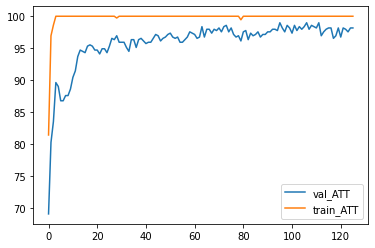

In [115]:
states[['val_ATT','train_ATT']].plot()

<AxesSubplot:>

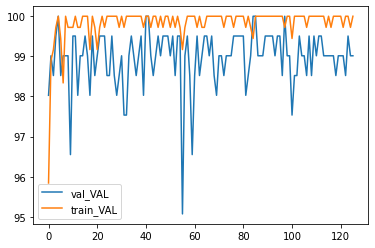

In [116]:
states[['val_VAL','train_VAL']].plot()

<AxesSubplot:>

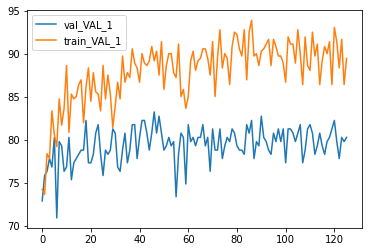

In [117]:
states[['val_VAL_1','train_VAL_1']].plot()

<AxesSubplot:>

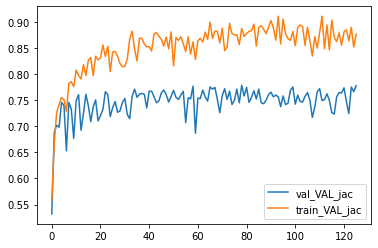

In [118]:
states[['val_VAL_jac','train_VAL_jac']].plot()

In [119]:
unlabel_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=~(data.train_mask + data.val_mask + data.test_mask),
)

In [120]:
@torch.no_grad()
def predict_Homo(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch.batch_size
        #edge_index = to_undirected(batch.edge_index)
        out = model(batch.x)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch.n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [121]:
pred_train = predict_Homo(model, train_loader)
pred_val = predict_Homo(model, val_loader)
pred_test = predict_Homo(model, test_loader)
pred_unlab = predict_Homo(model, unlabel_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 73.47it/s]


In [122]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [123]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [124]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.021555,0.099800,0.012440,0.009709,0.238287,0.136117,0.042519,0.006944,0.432629,0.056437,0.318523,0.264389,0.231813,0.015072,0.095696,0.002628,0.001783,0.002582,0.003020,0.008057
1.0,0.011781,0.037312,0.006450,0.004553,0.040292,0.043186,0.010875,0.004713,0.840839,0.119712,0.412343,0.214445,0.125116,0.016628,0.082014,0.005115,0.003278,0.004943,0.005984,0.010422
2.0,0.047308,0.089104,0.019904,0.012865,0.214152,0.330976,0.058205,0.014936,0.212550,0.109006,0.324120,0.258103,0.159002,0.012958,0.109527,0.004611,0.003401,0.003815,0.004318,0.011139
3.0,0.030690,0.140461,0.035073,0.012410,0.009325,0.031827,0.684635,0.046914,0.008666,0.059222,0.040448,0.178818,0.074877,0.021621,0.581006,0.012006,0.008276,0.005939,0.007297,0.010490
4.0,0.368223,0.291382,0.006805,0.076779,0.020741,0.173170,0.041746,0.010219,0.010934,0.189621,0.075349,0.100124,0.297412,0.015744,0.295089,0.005760,0.004349,0.002846,0.003156,0.010550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.027841,0.508675,0.119450,0.030187,0.012398,0.030492,0.203104,0.045802,0.022050,0.285283,0.189706,0.215706,0.182972,0.032010,0.042161,0.008416,0.007815,0.007482,0.010901,0.017548
2947.0,0.005524,0.029289,0.350625,0.023732,0.005754,0.005032,0.475743,0.094678,0.009623,0.253265,0.177734,0.251875,0.166296,0.024077,0.073485,0.008465,0.008517,0.006828,0.012216,0.017243
2948.0,0.082219,0.573929,0.071733,0.023898,0.024530,0.037873,0.124089,0.042005,0.019725,0.286234,0.194948,0.213093,0.188490,0.035445,0.033786,0.009093,0.007172,0.007361,0.010529,0.013848


In [125]:
preds_df.to_csv(args.save_dir + 'preds.csv', sep='\t')

In [126]:
states.to_csv(args.save_dir + 'train_state.csv', sep='\t')

## Per-Class Metrics

In [127]:
from sklearn.metrics import confusion_matrix

In [128]:
preds = pd.read_csv(args.save_dir + 'preds.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.021555,0.099800,0.012440,0.009709,0.238287,0.136117,0.042519,0.006944,0.432629,0.056437,0.318522,0.264389,0.231813,0.015072,0.095696,0.002628,0.001783,0.002582,0.003020,0.008057
1.0,0.011781,0.037312,0.006450,0.004553,0.040292,0.043186,0.010875,0.004713,0.840839,0.119712,0.412343,0.214445,0.125116,0.016628,0.082014,0.005115,0.003278,0.004943,0.005984,0.010422
2.0,0.047308,0.089104,0.019904,0.012865,0.214152,0.330976,0.058205,0.014936,0.212550,0.109006,0.324120,0.258103,0.159002,0.012958,0.109527,0.004611,0.003401,0.003815,0.004318,0.011139
3.0,0.030690,0.140460,0.035073,0.012410,0.009325,0.031827,0.684635,0.046914,0.008666,0.059222,0.040448,0.178818,0.074877,0.021621,0.581005,0.012006,0.008276,0.005939,0.007297,0.010490
4.0,0.368223,0.291382,0.006805,0.076779,0.020741,0.173170,0.041746,0.010219,0.010934,0.189621,0.075349,0.100124,0.297412,0.015744,0.295089,0.005760,0.004349,0.002846,0.003156,0.010550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.027841,0.508675,0.119450,0.030187,0.012398,0.030492,0.203104,0.045802,0.022050,0.285283,0.189706,0.215706,0.182972,0.032010,0.042161,0.008416,0.007815,0.007482,0.010901,0.017548
2947.0,0.005524,0.029289,0.350625,0.023732,0.005754,0.005032,0.475743,0.094678,0.009623,0.253265,0.177734,0.251875,0.166296,0.024077,0.073485,0.008465,0.008517,0.006828,0.012216,0.017243
2948.0,0.082219,0.573929,0.071733,0.023898,0.024530,0.037873,0.124089,0.042005,0.019725,0.286234,0.194948,0.213093,0.188490,0.035445,0.033786,0.009093,0.007172,0.007361,0.010529,0.013848


In [129]:
pred = torch.tensor(np.array(preds)).to(device)

In [130]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [131]:
test_ATT_conf = confusion_matrix(data.y[(data.att_lab) * data.test_mask][:,:9].argmax(axis=1).cpu(), 
                                 pred[(data.att_lab) * data.test_mask][:,:9].argmax(axis=1).cpu(), labels = range(9))
test_VAL_conf = confusion_matrix(data.y[(data.val_lab) * data.test_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data.val_lab) * data.test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data.y[(data.val_lab) * data.test_mask][:,9:].cpu(),  
                                 pred[(data.val_lab) * data.test_mask][:,9:].cpu(),3)).astype(int)

In [132]:
test_ATT_conf

array([[ 64,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 144,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,  10,   0,   0,   0,   0,   1,   0],
       [  1,   0,   0,  17,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  72,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0, 101,   0,   0,   0],
       [  0,   1,   0,   0,   2,   0,  74,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0,   1,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,  11]], dtype=int64)

In [133]:
test_VAL_conf

array([[54,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 20,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  6, 19,  2,  0,  7,  0,  0,  0,  0,  0],
       [ 2,  1,  3, 26,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  5,  2,  2,  0, 34,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [134]:
test_VAL_conf_k

array([[ 90,  61,  48,  47,   0,  36,   0,   0,   0,   0,   0],
       [ 50,  87,  78,  64,   1,  29,   0,   0,   0,   0,   0],
       [ 56,  84, 112,  93,   1,  61,   1,   0,   0,   0,   0],
       [ 56,  79,  91, 118,   1,  54,   0,   0,   0,   0,   0],
       [  0,   3,   3,   3,   0,   0,   0,   0,   0,   0,   0],
       [ 45,  40,  72,  74,   0,  77,   1,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   2,   2,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   1,   1,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   1,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [135]:
val_ATT_conf = confusion_matrix(data.y[(data.att_lab) * data.val_mask][:,:9].argmax(axis=1).cpu(), 
                                pred[(data.att_lab) * data.val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data.y[(data.val_lab) * data.val_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data.val_lab) * data.val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data.y[(data.val_lab) * data.val_mask][:,9:].cpu(),  
                                 pred[(data.val_lab) * data.val_mask][:,9:].cpu(),3)).astype(int)

In [136]:
val_ATT_conf

array([[ 61,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 145,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   8,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  22,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  75,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0, 102,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  62,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   4,   0],
       [  0,   0,   0,   0,   2,   0,   0,   0,   8]], dtype=int64)

In [137]:
val_VAL_conf

array([[61,  3,  2,  2,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 14,  1,  3,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  1, 22,  4,  0,  4,  0,  0,  0,  0,  0],
       [ 1,  1,  0, 32,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  5,  4,  2,  0, 35,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [138]:
val_VAL_conf_k

array([[ 99,  65,  59,  60,   0,  41,   0,   0,   0,   0,   0],
       [ 56,  88,  68,  70,   5,  34,   0,   0,   0,   0,   0],
       [ 46,  64, 113,  96,   1,  73,   0,   0,   0,   0,   0],
       [ 62,  89,  92, 123,   5,  55,   0,   0,   0,   0,   0],
       [  0,   8,   4,   8,   4,   0,   0,   0,   0,   0,   0],
       [ 43,  43,  93,  72,   0,  88,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [139]:
pd.concat([pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT.csv')
pd.concat([pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL.csv')
pd.concat([pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k.csv')

In [140]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [141]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [142]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [143]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [144]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [145]:
metrics_df.to_csv(args.save_dir+'per_class_metrics.csv')

## Masking Visual and Textual Features

In [29]:
model = MLP(in_channels=data.x.shape[-1], hidden_channels = 256, 
            out_channels = data.y.shape[-1], dropout = 0.1, num_layers=3).to(device)

In [30]:
model

MLP(1753, 256, 256, 20)

In [31]:
model.load_state_dict(torch.load(args.save_dir+'MLP_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [38]:
sampled_data = next(iter(train_loader))
batch = sampled_data
batch

Data(num_nodes=2921, x=[2921, 1753], y=[2921, 20], node_type=[2921], att_lab=[2921], val_lab=[2921], train_mask=[2921], val_mask=[2921], test_mask=[2921], edge_index=[2, 104214], edge_attr=[104214], n_id=[2921], batch_size=32)

In [39]:
batch.x[:32,:982] = torch.zeros(32,982)
batch.x

tensor([[0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.4269, 2.1218, 0.6201,  ..., 0.0000, 1.0000, 0.0000],
        [0.6513, 0.2455, 1.4309,  ..., 1.0000, 0.0000, 0.0000],
        [0.0303, 0.2407, 0.1925,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [40]:
@torch.no_grad()
def test_Mask(model, loader, mask = None):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_1_val = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch = batch.to(device)
        batch_size = batch.batch_size
        
        if mask == 'vis':
            batch.x[:batch_size,:982] = torch.zeros(batch_size,982)
        elif mask == 'tex':
            batch.x[:batch_size,982:] = torch.zeros(batch_size,771)
        
        #edge_index = to_undirected(batch.edge_index)
        out = model(batch.x)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch.att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch.val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]
    
    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val


In [43]:
test_Mask(model, train_loader, 'vis')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.23it/s]


(2.1408802029828946,
 1.6458789093672734,
 13.296398891966758,
 99.7229916897507,
 0.7248384206248782,
 76.17728531855956)

In [44]:
test_Mask(model, train_loader, 'tex')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.77it/s]


(0.7581068843685689,
 1.9154196657302307,
 99.7229916897507,
 73.13019390581718,
 0.10803324099722991,
 31.024930747922436)

In [46]:
test_Mask(model, val_loader, 'vis')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 37.16it/s]


(2.232890134419852,
 1.6475393995275638,
 14.227642276422765,
 99.50738916256158,
 0.7545156032581047,
 80.78817733990148)

In [47]:
test_Mask(model, val_loader, 'tex')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 38.23it/s]


(0.7890427937594856,
 2.052411281416569,
 99.1869918699187,
 60.09852216748769,
 0.012315270935960592,
 23.15270935960591)

In [48]:
test_Mask(model, test_loader, 'vis')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 40.42it/s]


(2.249690012239794,
 1.6597018192211788,
 15.109343936381709,
 100.0,
 0.7708333358168602,
 79.16666666666667)

In [49]:
test_Mask(model, test_loader, 'tex')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 40.84it/s]


(0.796224286968618,
 2.0458929960926375,
 99.00596421471172,
 59.895833333333336,
 0.028645833333333332,
 25.0)

In [50]:
val_numbers_vis = []
val_numbers_tex = []
test_numbers_vis = []
test_numbers_tex = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers_vis.append(test_Mask(model, val_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    val_numbers_tex.append(test_Mask(model, val_loader, 'tex'))
    
    set_seed_everywhere(seed, args.cuda)
    test_numbers_vis.append(test_Mask(model, test_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers_tex.append(test_Mask(model, test_loader, 'tex'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 53.14it/s]


In [51]:
val_df_vis = pd.DataFrame(val_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
val_df_tex = pd.DataFrame(val_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_vis = pd.DataFrame(test_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_tex = pd.DataFrame(test_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [52]:
val_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,10.000000,10.000000,1.000000e+01,10.000000
mean,2.232890e+00,1.647539e+00,14.227642,99.507389,7.545156e-01,80.788177
std,4.681111e-16,2.340556e-16,0.000000,0.000000,1.170278e-16,0.000000
min,2.232890e+00,1.647539e+00,14.227642,99.507389,7.545156e-01,80.788177
25%,2.232890e+00,1.647539e+00,14.227642,99.507389,7.545156e-01,80.788177
50%,2.232890e+00,1.647539e+00,14.227642,99.507389,7.545156e-01,80.788177
75%,2.232890e+00,1.647539e+00,14.227642,99.507389,7.545156e-01,80.788177
max,2.232890e+00,1.647539e+00,14.227642,99.507389,7.545156e-01,80.788177


In [53]:
val_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,1.000000e+01
mean,7.890428e-01,2.052411e+00,9.918699e+01,6.009852e+01,0.012315,2.315271e+01
std,1.170278e-16,4.681111e-16,1.497956e-14,1.497956e-14,0.000000,3.744889e-15
min,7.890428e-01,2.052411e+00,9.918699e+01,6.009852e+01,0.012315,2.315271e+01
25%,7.890428e-01,2.052411e+00,9.918699e+01,6.009852e+01,0.012315,2.315271e+01
50%,7.890428e-01,2.052411e+00,9.918699e+01,6.009852e+01,0.012315,2.315271e+01
75%,7.890428e-01,2.052411e+00,9.918699e+01,6.009852e+01,0.012315,2.315271e+01
max,7.890428e-01,2.052411e+00,9.918699e+01,6.009852e+01,0.012315,2.315271e+01


In [54]:
test_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,10.000000,10.0,10.000000,1.000000e+01
mean,2.249690e+00,1.659702e+00,15.109344,100.0,0.770833,7.916667e+01
std,4.681111e-16,2.340556e-16,0.000000,0.0,0.000000,1.497956e-14
min,2.249690e+00,1.659702e+00,15.109344,100.0,0.770833,7.916667e+01
25%,2.249690e+00,1.659702e+00,15.109344,100.0,0.770833,7.916667e+01
50%,2.249690e+00,1.659702e+00,15.109344,100.0,0.770833,7.916667e+01
75%,2.249690e+00,1.659702e+00,15.109344,100.0,0.770833,7.916667e+01
max,2.249690e+00,1.659702e+00,15.109344,100.0,0.770833,7.916667e+01


In [55]:
test_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,10.000000,10.0
mean,7.962243e-01,2.045893e+00,9.900596e+01,59.895833,0.028646,25.0
std,1.170278e-16,4.681111e-16,1.497956e-14,0.000000,0.000000,0.0
min,7.962243e-01,2.045893e+00,9.900596e+01,59.895833,0.028646,25.0
25%,7.962243e-01,2.045893e+00,9.900596e+01,59.895833,0.028646,25.0
50%,7.962243e-01,2.045893e+00,9.900596e+01,59.895833,0.028646,25.0
75%,7.962243e-01,2.045893e+00,9.900596e+01,59.895833,0.028646,25.0
max,7.962243e-01,2.045893e+00,9.900596e+01,59.895833,0.028646,25.0


In [56]:
val_df_vis.to_csv(args.save_dir + 'vis_masked_val_metrics.csv', sep='\t')
val_df_tex.to_csv(args.save_dir + 'tex_masked_val_metrics.csv', sep='\t')
test_df_vis.to_csv(args.save_dir + 'vis_masked_test_metrics.csv', sep='\t')
test_df_tex.to_csv(args.save_dir + 'tex_masked_test_metrics.csv', sep='\t')

## Direct Prediction on VEN-XL

In [15]:
device = torch.device("cpu")
#device = torch.device("cpu")
print(device)

cpu


In [16]:
#path = osp.join(os.getcwd(), '../../data/VEN')
#transform = T.Compose([T.NormalizeFeatures(), T.ToSparseTensor()])
dataset_XL = VEN_XL_Homo('dataset/Venice_XL_homo')
data_XL = dataset_XL[0]

In [17]:
data_XL.n_id = torch.arange(data_XL.num_nodes)
data_XL = data_XL.to(device)
data_XL

Data(num_nodes=80963, x=[80963, 1753], y=[80963, 20], att_lab=[80963], val_lab=[80963], node_type=[80963], train_mask=[80963], val_mask=[80963], test_mask=[80963], edge_index=[2, 290091503], edge_attr=[290091503], n_id=[80963])

In [18]:
from torch_geometric.loader import NeighborLoader

In [19]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.train_mask,
)

In [ ]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.val_mask,
)
seed_everything(args.seed)
test_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=data_XL.test_mask,
)
unlabel_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors=[3*args.sample_nodes] * 2,
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=~(data_XL.train_mask + data_XL.val_mask + data_XL.test_mask),
)

In [20]:
sampled_data = next(iter(train_loader))
batch = sampled_data
batch

Data(num_nodes=53788, x=[53788, 1753], y=[53788, 20], att_lab=[53788], val_lab=[53788], node_type=[53788], train_mask=[53788], val_mask=[53788], test_mask=[53788], edge_index=[2, 170325], edge_attr=[170325], n_id=[53788], batch_size=32)

In [189]:
model = MLP(in_channels=data_XL.x.shape[-1], hidden_channels = 256, 
            out_channels = data_XL.y.shape[-1], dropout = 0.1, num_layers=3).to(device)

In [190]:
model.load_state_dict(torch.load(args.save_dir+'MLP_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [191]:
@torch.no_grad()
def predict_Homo(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch.batch_size
        #edge_index = to_undirected(batch.edge_index)
        out = model(batch.x)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch.n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [192]:
pred_train = predict_Homo(model, train_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [01:51<00:00,  3.24it/s]


In [193]:
pred_val = predict_Homo(model, val_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [03:18<00:00,  3.15it/s]


In [194]:
pred_test = predict_Homo(model, test_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [03:07<00:00,  3.33it/s]


In [205]:
pred_unlab = predict_Homo(model, unlabel_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 921/921 [04:15<00:00,  3.60it/s]


In [206]:
pred_train[0]

tensor([4.0000e+00, 6.4191e-03, 9.3232e-01, 4.7782e-03, 2.2493e-03, 1.4609e-03,
        3.6227e-02, 8.7789e-03, 1.3225e-03, 6.4492e-03, 2.4002e-02, 1.2366e-01,
        1.9101e-01, 4.7043e-01, 8.0229e-02, 9.2186e-02, 2.5333e-03, 2.0446e-03,
        2.9066e-03, 3.2552e-03, 7.7464e-03])

In [207]:
preds = torch.vstack([pred_train, pred_val, pred_test]).cpu()

In [208]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [209]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [210]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.594535,0.048073,0.019625,0.041608,0.014619,0.190502,0.038185,0.023982,0.028871,0.189272,0.116634,0.180595,0.374547,0.029213,0.074395,0.005818,0.005557,0.004208,0.004887,0.014874
1.0,0.362458,0.031278,0.002685,0.012323,0.004354,0.555326,0.007800,0.005447,0.018330,0.219277,0.125396,0.120398,0.418638,0.021438,0.072530,0.003081,0.003248,0.002418,0.003077,0.010500
2.0,0.029422,0.369658,0.014396,0.015661,0.348402,0.030611,0.122547,0.009769,0.059534,0.065325,0.065170,0.111108,0.086168,0.018429,0.547296,0.039902,0.022893,0.012779,0.015562,0.015368
3.0,0.020930,0.221499,0.030887,0.026482,0.068644,0.072682,0.492496,0.025842,0.040539,0.049214,0.130924,0.147752,0.228507,0.068703,0.262241,0.029974,0.021974,0.020983,0.020707,0.019022
4.0,0.006419,0.932315,0.004778,0.002249,0.001461,0.036227,0.008779,0.001323,0.006449,0.024002,0.123658,0.191009,0.470429,0.080229,0.092186,0.002533,0.002045,0.002907,0.003255,0.007746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.053355,0.323336,0.013751,0.010410,0.013495,0.446532,0.037435,0.007922,0.093765,0.086527,0.306084,0.176422,0.301726,0.014634,0.093429,0.002878,0.002736,0.003200,0.002976,0.009389
80959.0,0.924019,0.016786,0.001945,0.030483,0.005963,0.008671,0.005393,0.005177,0.001564,0.188021,0.354948,0.172444,0.192030,0.010255,0.065905,0.001918,0.002253,0.001935,0.001957,0.008335
80960.0,0.830574,0.035322,0.003268,0.051942,0.009040,0.044200,0.012632,0.009196,0.003826,0.253837,0.203410,0.197328,0.168720,0.009609,0.139658,0.004125,0.004363,0.002813,0.003385,0.012753


In [211]:
preds_df.to_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t')

## Evaluation Metrics

In [212]:
preds = pd.read_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.594534,0.048073,0.019625,0.041608,0.014619,0.190502,0.038185,0.023982,0.028871,0.189272,0.116634,0.180595,0.374547,0.029213,0.074395,0.005818,0.005557,0.004208,0.004887,0.014874
1.0,0.362457,0.031278,0.002685,0.012323,0.004354,0.555326,0.007800,0.005447,0.018330,0.219277,0.125396,0.120398,0.418638,0.021438,0.072530,0.003081,0.003248,0.002418,0.003077,0.010500
2.0,0.029422,0.369658,0.014396,0.015661,0.348402,0.030611,0.122547,0.009769,0.059534,0.065325,0.065170,0.111108,0.086168,0.018429,0.547296,0.039902,0.022893,0.012779,0.015562,0.015368
3.0,0.020930,0.221499,0.030887,0.026482,0.068644,0.072682,0.492496,0.025842,0.040539,0.049214,0.130924,0.147752,0.228507,0.068703,0.262241,0.029974,0.021974,0.020983,0.020707,0.019022
4.0,0.006419,0.932315,0.004778,0.002249,0.001461,0.036227,0.008779,0.001323,0.006449,0.024002,0.123658,0.191009,0.470429,0.080229,0.092186,0.002533,0.002045,0.002907,0.003255,0.007746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.053355,0.323336,0.013751,0.010410,0.013495,0.446532,0.037435,0.007922,0.093765,0.086527,0.306084,0.176422,0.301727,0.014634,0.093429,0.002878,0.002736,0.003200,0.002976,0.009389
80959.0,0.924019,0.016786,0.001945,0.030483,0.005963,0.008671,0.005393,0.005177,0.001564,0.188021,0.354948,0.172444,0.192030,0.010255,0.065905,0.001918,0.002253,0.001935,0.001957,0.008335
80960.0,0.830574,0.035322,0.003268,0.051942,0.009040,0.044200,0.012632,0.009196,0.003826,0.253837,0.203410,0.197328,0.168720,0.009609,0.139658,0.004125,0.004363,0.002813,0.003385,0.012753


In [213]:
pred = torch.tensor(np.array(preds)).to(device)

In [214]:
eval_df = pd.DataFrame(('val_ATT_loss', 'val_VAL_loss', 'val_ATT_acc', 'val_VAL_acc', 'val_VAL_acc_k', 'val_VAL_jac_k'), columns=['name'])

In [215]:
train_ATT_loss = F.cross_entropy(data_XL.y[data_XL.train_mask][:,:9], 
                pred[data_XL.train_mask][:,:9]).cpu().detach().item()
train_VAL_loss = F.cross_entropy(data_XL.y[data_XL.train_mask][:,9:], 
                pred[data_XL.train_mask][:,9:]).cpu().detach().item()

train_ATT_acc = compute_1_accuracy(data_XL.y[data_XL.train_mask][:,:9], 
                pred[data_XL.train_mask][:,:9])
train_VAL_acc = compute_1_accuracy(data_XL.y[data_XL.train_mask][:,9:], 
                pred[data_XL.train_mask][:,9:])
train_VAL_acc_k = compute_k_accuracy(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                pred[data_XL.train_mask][:,9:].cpu(),3)
train_VAL_jac_k = compute_jaccard_index(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                pred[data_XL.train_mask][:,9:].cpu(),3)

In [216]:
eval_df['train'] = pd.DataFrame((train_ATT_loss, train_VAL_loss, train_ATT_acc, train_VAL_acc, train_VAL_acc_k, train_VAL_jac_k))

In [218]:
val_ATT_loss = F.cross_entropy(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9]).cpu().detach().item()
val_VAL_loss = F.cross_entropy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:]).cpu().detach().item()

val_ATT_acc = compute_1_accuracy(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9])
val_VAL_acc = compute_1_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:])
val_VAL_acc_k = compute_k_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)
val_VAL_jac_k = compute_jaccard_index(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)

In [219]:
eval_df['val'] = pd.DataFrame((val_ATT_loss, val_VAL_loss, val_ATT_acc, val_VAL_acc, val_VAL_acc_k, val_VAL_jac_k))

In [220]:
test_ATT_loss = F.cross_entropy(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9]).cpu().detach().item()
test_VAL_loss = F.cross_entropy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:]).cpu().detach().item()

test_ATT_acc = compute_1_accuracy(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9], 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9])
test_VAL_acc = compute_1_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:], 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:])
test_VAL_acc_k = compute_k_accuracy(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)
test_VAL_jac_k = compute_jaccard_index(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)

In [221]:
eval_df['test'] = pd.DataFrame((test_ATT_loss, test_VAL_loss, test_ATT_acc, test_VAL_acc, test_VAL_acc_k, test_VAL_jac_k))

In [222]:
eval_df

,name,train,val,test
0,val_ATT_loss,1.749471,1.740666,1.740848
1,val_VAL_loss,2.250396,2.248371,2.247688
2,val_ATT_acc,91.580949,96.860673,96.794024
3,val_VAL_acc,79.159824,80.527355,80.520394
4,val_VAL_acc_k,98.668856,98.702764,98.860759
5,val_VAL_jac_k,0.744237,0.752468,0.752192


In [223]:
eval_df.to_csv(args.save_dir+'eval_metrics_XL_trans.csv')

## Per-Class Metrics

In [224]:
from sklearn.metrics import confusion_matrix

In [225]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [227]:
test_ATT_conf = confusion_matrix(data_XL.y[(data_XL.att_lab) * data_XL.test_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL.att_lab) * data_XL.test_mask][:,:9].argmax(axis=1).cpu())
test_VAL_conf = confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.test_mask][:,9:].cpu(),3)).astype(int)

In [228]:
test_ATT_conf

array([[1371,    2,    0,    5,    1,    8,    2,    0,    0],
       [   4, 3194,    0,    2,    2,    5,    4,    0,    0],
       [   0,    0,  233,    0,    0,    0,   31,    1,    0],
       [  22,    1,    0,  603,    0,    1,    9,    1,    0],
       [   1,    2,    0,    0, 2694,    0,    7,    0,    0],
       [   4,   19,    0,    2,    5, 1551,    2,    0,    0],
       [   3,   13,    0,    1,    5,    0, 2569,    2,    0],
       [  14,    3,   20,   14,    0,    0,  150,  112,    0],
       [   1,   11,    0,    0,   19,   13,    0,    0,  112]],
      dtype=int64)

In [229]:
test_VAL_conf

array([[ 524,   52,   33,   15,    0,   56,    0,    0,    0,    0,    0],
       [  23,  577,   70,   61,    0,  118,    0,    0,    0,    0,    0],
       [  27,   96, 1066,   63,    0,  355,    0,    0,    0,    0,    0],
       [  20,   17,   44,  393,    0,   62,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  23,   28,  169,   43,    0, 3152,    0,    0,    0,    0,    0],
       [   1,    0,    0,    0,    0,    4,    6,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    1,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    2,    0,    0,    7,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [230]:
test_VAL_conf_k

array([[1250,  852, 1229,  818,    0,  800,    4,    0,    0,    0,    0],
       [ 784, 1722, 2330, 1774,    2, 1593,    3,    0,    0,    0,    0],
       [ 806, 1544, 5855, 4774,    4, 5090,   11,    0,    0,    0,    0],
       [ 735, 1443, 4845, 4611,    5, 4162,    3,    0,    0,    0,    0],
       [   0,    7,   17,   18,    2,   10,    0,    0,    0,    0,    0],
       [ 690,  987, 5311, 4439,    2, 5231,   10,    0,    0,    1,    0],
       [   7,    0,   14,    6,    0,   25,   23,    1,    3,   17,    0],
       [   1,    0,    1,    0,    0,    6,    6,    0,    1,    6,    0],
       [   1,    0,    1,    0,    0,   10,   14,    1,    2,   13,    0],
       [   1,    0,    2,    0,    0,   14,   19,    1,    3,   17,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [231]:
data_XL.val_mask[data_XL.val_mask + data_XL.train_mask]

tensor([ True,  True, False,  ...,  True,  True,  True])

In [232]:
val_ATT_conf = confusion_matrix(data_XL.y[(data_XL.att_lab) * data_XL.val_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL.att_lab) * data_XL.val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),  
                pred[(data_XL.val_lab) * data_XL.val_mask][:,9:].cpu(),3)).astype(int)

In [233]:
val_ATT_conf

array([[1342,    1,    0,    4,    0,    3,    1,    1,    0],
       [   6, 3275,    0,    1,    0,    7,   10,    0,    0],
       [   0,    0,  258,    0,    0,    0,   19,    3,    0],
       [  33,    4,    0,  635,    0,    0,    7,    1,    0],
       [   1,    3,    0,    0, 2674,    0,    8,    1,    0],
       [   9,   19,    0,    3,    4, 1452,    1,    0,    0],
       [   3,   12,    1,    0,    4,    0, 2609,    1,    0],
       [  11,    1,   23,   10,    0,    0,  146,   95,    0],
       [   0,    8,    0,    0,   26,    8,    0,    0,  125]],
      dtype=int64)

In [234]:
val_VAL_conf

array([[ 509,   42,   45,   26,    0,   45,    0,    0,    0,    0,    0],
       [  18,  569,   66,   78,    0,   98,    0,    0,    0,    0,    0],
       [  21,   85, 1101,   75,    0,  361,    0,    0,    0,    1,    0],
       [  22,   20,   42,  444,    0,   70,    0,    0,    0,    0,    0],
       [   0,    0,    1,    3,    0,    0,    0,    0,    0,    0,    0],
       [  22,   33,  165,   33,    0, 3079,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,    4,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,    1,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    1,    2,    0,    0,    5,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [235]:
val_VAL_conf_k

array([[1263,  864, 1228,  857,    0,  802,    2,    0,    0,    0,    0],
       [ 832, 1724, 2426, 1899,    8, 1644,    2,    0,    0,    0,    0],
       [ 825, 1545, 5811, 4743,    9, 5017,   18,    0,    0,    2,    0],
       [ 715, 1443, 4757, 4575,   15, 4054,    8,    0,    0,    0,    0],
       [   0,    7,   18,   21,   11,    8,    1,    0,    0,    0,    0],
       [ 661,  957, 5233, 4429,    2, 5142,   20,    0,    0,    2,    0],
       [   9,    0,   23,   14,    2,   32,   23,    1,    2,   14,    0],
       [   1,    0,    0,    0,    0,    3,    2,    0,    0,    3,    0],
       [   2,    0,    3,    0,    1,    9,   15,    1,    2,   15,    0],
       [   3,    0,    4,    1,    0,   11,   14,    1,    2,   15,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [236]:
train_ATT_conf = confusion_matrix(data_XL.y[data_XL.train_mask][:,:9].argmax(axis=1).cpu(), 
                                  pred[data_XL.train_mask][:,:9].argmax(axis=1).cpu())
train_VAL_conf = confusion_matrix(data_XL.y[data_XL.train_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[data_XL.train_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
train_VAL_conf_k = (top_k_confusion_matrix(data_XL.y[data_XL.train_mask][:,9:].cpu(),  
                                pred[data_XL.train_mask][:,9:].cpu(),3)).astype(int)

In [241]:
data_XL.train_mask.sum()

tensor(11569)

In [237]:
train_ATT_conf

array([[1479,    2,    0,    1,    1,   12,    6,    0,    0],
       [   0, 2617,    0,    3,    0,    6,   10,    0,    0],
       [   2,    2,   92,    0,    0,    0,   42,    1,    0],
       [  38,   14,    0,  403,    0,    0,   24,    1,    0],
       [   5,    8,    0,    0, 2008,    0,   28,    2,    0],
       [   6,   42,    0,    1,    8, 1449,    1,    0,    0],
       [   2,   19,    0,    2,    1,    0, 2431,    2,    0],
       [  22,    5,    8,    8,    0,    0,  578,   64,    0],
       [   0,   15,    0,    0,   34,   12,    0,    0,   52]],
      dtype=int64)

In [238]:
train_VAL_conf

array([[ 782,   66,   53,   22,    0,   89,    0,    0,    0,    0,    0],
       [  26,  889,  149,  120,    0,  194,    0,    0,    0,    0,    0],
       [  32,  144, 1872,   95,    0,  672,    0,    0,    0,    0,    0],
       [  20,   47,   90,  797,    0,   89,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0,    1,    0,    0,    0,    0,    0],
       [  38,   50,  306,   91,    0, 4798,    0,    0,    0,    0,    0],
       [   2,    0,    0,    1,    0,    5,   12,    0,    0,    1,    0],
       [   1,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    4,    0,    0,    8,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [239]:
train_VAL_conf_k

array([[1875, 1234, 1734, 1309,    0, 1233,    2,    0,    0,    2,    0],
       [1169, 2880, 4035, 3253,    5, 2767,    3,    0,    0,    0,    0],
       [1213, 2707, 9575, 7787,    4, 8289,   17,    0,    0,    0,    0],
       [1137, 2517, 7831, 7531,    9, 6699,   10,    0,    0,    0,    0],
       [   0,   25,   49,   53,    9,   26,    0,    0,    0,    0,    0],
       [1052, 1684, 8529, 7104,    0, 8374,   19,    0,    0,    1,    0],
       [  12,    2,   32,   17,    0,   43,   34,    2,    5,   27,    0],
       [   6,    0,    7,    3,    0,   12,   14,    1,    0,   11,    0],
       [   3,    0,    3,    0,    0,   10,   19,    1,    5,   16,    0],
       [   4,    0,    8,    0,    0,   15,   26,    2,    5,   24,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [250]:
pd.concat([pd.DataFrame(train_ATT_conf),pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf),pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf_k),pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k_XL_trans.csv')

In [251]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [252]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [253]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [254]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [255]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [256]:
metrics_df

precision    recall  \
test_ATT  Building Elements                         0.987041  0.965493   
          Urban Form Elements                       0.994706  0.984284   
          Gastronomy                                0.879245  0.920949   
          Interior Scenery                          0.946625  0.961722   
          Natural Features and Land-scape Scenery   0.996302  0.988261   
...                                                      ...       ...   
val_VAL_k Criterion vii                             0.575000  0.657143   
          Criterion viii                            0.000000  0.000000   
          Criterion ix                              0.125000  1.000000   
          Criterion x                               0.882353  0.882353   
          Others                                    0.000000  0.000000   

                                                         F1  
test_ATT  Building Elements                        0.976148  
          Urban Form Elements                      0.989467  
          Gastronomy                               0.899614  
          Interior Scenery                         0.954114  
          Natural Features and Land-scape Scenery  0.992265  
...                                                     ...  
val_VAL_k Criterion vii                            0.613333  
          Criterion viii                           0.000000  
          Criterion ix                             0.222222  
          Criterion x                              0.882353  
          Others                                   0.000000  

[62 rows x 3 columns]

In [257]:
metrics_df.to_csv(args.save_dir+'per_class_metrics_XL_trans.csv')